# SCDAA Group Assignment 2024

## Exercise 4

In [2]:
import numpy as np
import torch
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from torch import nn, optim
import tqdm

In [3]:
# Define the matrices
H = np.array([[1, 0], [0, 1]]) * 0.1
M = np.array([[1, 0], [0, 1]])
sigma = np.array([[1, 0], [0, 1]]) * 0.001
C = np.array([[0, 0], [0, 0]])
D = np.array([[1, 0], [0, 1]])
R = np.array([[1, 0], [0, 1]]) * 10

# Initial and terminal times
t0 = 0.0
T = 1.0
# n = 100
time_tensor_dim = 1
space_tensor_dim = 1 * 2

# Initial state vector
x0 = torch.tensor([1.0, 1.0])

dmg_hidden_layer_size = 100

In [4]:
class LQRProblem:
    def __init__(self, H, M, C, D, R, sigma, T):
        """
        Initializes the LQR problem with the given matrices and time horizon T.
        """
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
        self.sigma = sigma
        self.T = T
        self.S_solution, self.time_solution = None, None  # Will be set after solving Riccati ODE
    
    def riccati_ode(self, t, S_flat, H, M, D_inv, C):
        """
        Defines the Riccati differential equation.
        """
        S = S_flat.reshape(2, 2)
        dSdt = -2 * H.T @ S + S @ M @ D_inv @ M.T @ S - C
        return dSdt.flatten()
    
    def solve_riccati_ode(self, time_grid, atol=1e-10, rtol=1e-10):
        """
        Solves the Riccati ODE on the given time grid using scipy's solve_ivp.
        """
        D_inv = np.linalg.inv(self.D)
        S0_flat = self.R.flatten()
        sol = solve_ivp(
            self.riccati_ode, 
            [self.T, time_grid[0]], 
            S0_flat, 
            t_eval=time_grid[::-1], 
            args=(self.H, self.M, D_inv, self.C), 
            atol=atol, 
            rtol=rtol,
            method='Radau'  # This is a common choice for stiff ODEs
        )
        self.S_solution = sol.y.reshape(2, 2, len(time_grid))[:, :, ::-1]
        self.time_solution = sol.t[::-1]
        return self.S_solution, self.time_solution


    def compute_value_function(self, t_tensor, x_tensor):
        """
        Computes the control problem value v(t, x) for a batch of space x using the solution of S
        and includes the integral term.
        """
       
        batch_size = x_tensor.shape[0]
        
        # Convert all relevant data to PyTorch tensors
        sigma_tensor = torch.tensor(self.sigma, dtype=torch.float64)
        S_tensor = torch.tensor(self.S_solution.copy(), dtype=torch.float64)
        solution_time = torch.tensor(self.time_solution.copy(), dtype=torch.float64)
        dt = solution_time[1] - solution_time[0]
        
        sigma_squared = sigma_tensor @ sigma_tensor.T
        
        # Ensure t_tensor is 2D for broadcasting
        t_tensor = t_tensor.unsqueeze(1)
        
        # Find indexes where t_tensor < solution_time for all t_tensor in parallel
        # Convert the boolean tensor to float for compatibility with torch.argmax
        time_indexes = torch.argmax((t_tensor <= solution_time).to(dtype=torch.float64), dim=1)
        
        # Initialize v
        v = torch.zeros(batch_size, 1, dtype=torch.float64)
        
        # Pre-compute trace values for each S_tensor slice, to be used in batch operations
        trace_values = torch.einsum('ij,jik->k', sigma_squared, S_tensor)
        
        # Compute the cumulative sum of trace values for integral computation
        cum_integral = torch.cumsum(trace_values, dim=0) * dt
        
        # Adjust cum_integral by subtracting the cumulative sum up to each t, to effectively start from each t
        adjusted_integral = cum_integral[-1] - cum_integral
        
        for i in range(batch_size):
            idx = time_indexes[i]
            
            # Calculate the integral from t to T
            integral_term = adjusted_integral[idx]
            
            # Calculate v for each batch
            S_at_t = S_tensor[:, :, idx]

            if x_tensor[i].shape != (1, 2):
                x_T = x_tensor[i].reshape(1, 2)
                x = x_tensor[i].reshape(1, 2).T
            v[i] = x_T @ S_at_t @ x + integral_term

        return v

    def compute_markov_control(self, t_tensor, x_tensor):
        """
        Computes the Markov control function for a batch of x at time t using S(t).
        """
        batch_size = x_tensor.shape[0]

        # Find the index corresponding to the nearest time point in the time grid
        solution_time = torch.tensor(self.time_solution.copy(), dtype=torch.float64)
        S_tensor = torch.tensor(self.S_solution.copy(), dtype=torch.float64)

        # # Ensure t_tensor is 2D for broadcasting
        # t_tensor = t_tensor.unsqueeze(1)
        if t_tensor.shape != (batch_size, 1):
            # Reshape t_tensor to [1, batch_size]
            t_tensor = t_tensor.reshape(batch_size, 1)

        if x_tensor.dtype != torch.float64:
            x_tensor = x_tensor.to(torch.float64)

        if x_tensor.shape != (batch_size, 2):
            x_tensor = x_tensor.reshape(batch_size, 2)

        # Find indexes where t_tensor < solution_time for all t_tensor in parallel
        # Convert the boolean tensor to float for compatibility with torch.argmax
        time_indexes = torch.argmax((t_tensor <= solution_time).to(dtype=torch.float64), dim=1)

        # Initialize control
        control = torch.zeros(batch_size, 2, 1, dtype=torch.float64)

        D_inv = torch.tensor(np.linalg.inv(self.D), dtype=torch.float64)
        M_T = torch.tensor(self.M.T, dtype=torch.float64)

        # Compute the control using S(t)
        for i in range(batch_size):
            S_t = S_tensor[:, :, time_indexes[i]]

            if x_tensor[i].shape != (1, 2):
                x_T = x_tensor[i].reshape(1, 2).T

            control[i] = - D_inv @ M_T @ S_t @ x_T

        return control


In [5]:
class DGM_Layer(nn.Module):
    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(DGM_Layer, self).__init__()

        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))


        self.gate_Z = self.layer(dim_x+dim_S, dim_S)
        self.gate_G = self.layer(dim_x+dim_S, dim_S)
        self.gate_R = self.layer(dim_x+dim_S, dim_S)
        self.gate_H = self.layer(dim_x+dim_S, dim_S)

    def layer(self, nIn, nOut):
        l = nn.Sequential(nn.Linear(nIn, nOut), self.activation)
        return l

    def forward(self, x, S):
        x_S = torch.cat([x,S],1)
        Z = self.gate_Z(x_S)
        G = self.gate_G(x_S)
        R = self.gate_R(x_S)

        input_gate_H = torch.cat([x, S*R],1)
        H = self.gate_H(input_gate_H)

        output = ((1-G))*H + Z*S
        return output

In [6]:
class Net_DGM(nn.Module):

    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(Net_DGM, self).__init__()

        self.dim = dim_x
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))

        self.input_layer = nn.Sequential(nn.Linear(dim_x+1, dim_S), self.activation).to(torch.float64)

        self.DGM1 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation).to(torch.float64)
        self.DGM2 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation).to(torch.float64)
        self.DGM3 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation).to(torch.float64)

        self.output_layer = nn.Linear(dim_S, 1).to(torch.float64)

    def forward(self,t,x):
        tx = torch.cat([t,x], 1)
        S1 = self.input_layer(tx)
        S2 = self.DGM1(tx,S1)
        S3 = self.DGM2(tx,S2)
        S4 = self.DGM3(tx,S3)
        output = self.output_layer(S4)
        return output

In [7]:
def get_gradient(output, x):
    grad = torch.autograd.grad(output, x, grad_outputs=torch.ones_like(output), create_graph=True, retain_graph=True, only_inputs=True)[0]
    return grad

def get_hessian(grad, x):
    hessian = torch.zeros(x.shape[0], x.shape [1],x.shape[1])
    for d in range(x.shape[1]):
        v = grad[:,d].view(-1,1)
        grad_2 = torch.autograd.grad(v,x,grad_outputs=torch.ones_like(v), only_inputs=True, create_graph=True, retain_graph=True)[0]
        hessian[:,d] = grad_2
    return hessian.to(torch.float64)

100%|██████████| 10000/10000 [1:06:44<00:00,  2.46it/s]

MSE Loss: 21.509534618265143


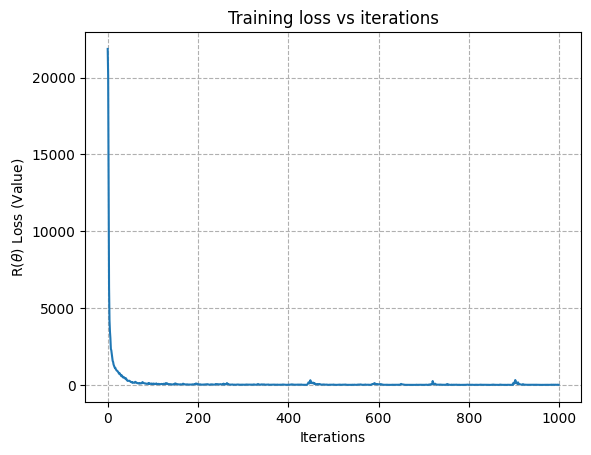

In [8]:
lqr_q_4 = LQRProblem(H, M, C, D, R, sigma, T)

# Time grid for solving the Riccati ODE
time_grid = np.linspace(t0, T, 10000)
lqr_q_4.solve_riccati_ode(time_grid)

class PDE_DGM_modified(torch.nn.Module):
    def __init__(self, H, M, C, D, R, sigma):
        super().__init__()
        self.H = torch.tensor(H, dtype=torch.float64)
        self.M = torch.tensor(M, dtype=torch.float64)
        self.C = torch.tensor(C, dtype=torch.float64)
        self.D = torch.tensor(D, dtype=torch.float64)
        self.R = torch.tensor(R, dtype=torch.float64)
        self.sigma = torch.tensor(sigma, dtype=torch.float64)
        self.sigma_sigma_t = self.sigma @ self.sigma.T
        self.net_dgm = Net_DGM(time_tensor_dim + space_tensor_dim + 2 - 1, 100, activation='Tanh')

    def fit(self, batch_size, num_epochs_limit, plot=True):
        # Create Adam optimizer
        optimizer = torch.optim.Adam(self.net_dgm.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = (10000,), gamma=0.1)

        loss_fn = torch.nn.MSELoss()

        # Train model
        pbar = tqdm.tqdm(total=num_epochs_limit)
        losses = []

        def sample_x_direct(batch_size, dim=2):
            samples = np.zeros((batch_size, dim))
            for d in range(dim):
                # Half the samples from one interval
                half_batch = batch_size // 2
                samples[:half_batch, d] = np.random.uniform(-3, -1.5, size=half_batch)
                # The other half from the second interval
                samples[half_batch:, d] = np.random.uniform(1.5, 3, size=(batch_size - half_batch))
                
                # Shuffle the samples in this dimension to mix intervals
                np.random.shuffle(samples[:, d])
            return samples

        for iter in range(num_epochs_limit):    
            
            t_tensor = torch.tensor(np.random.uniform(low=0, high=1, size=batch_size),requires_grad=True).unsqueeze(1)
            x_tensor = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size, 2)),requires_grad=True)

            alpha_train = lqr_q_4.compute_markov_control(t_tensor, x_tensor.detach().reshape(batch_size,1,2))
            alpha_train = alpha_train.squeeze()

            u_of_tx = self.forward_mod(t_tensor, x_tensor, alpha_train)
            grad_u_x = get_gradient(u_of_tx, x_tensor)
            grad_u_t = get_gradient(u_of_tx, t_tensor)
            hessian = get_hessian(grad_u_x, x_tensor)
            target_equation = torch.zeros_like(u_of_tx)
            
            trace_sigma_sigma_hessian = torch.matmul(self.sigma_sigma_t, hessian)
            trace_sigma_sigma_hessian = (0.5 * torch.vmap(torch.trace)(trace_sigma_sigma_hessian)).reshape(batch_size,1)
            H_x_grad = (grad_u_x *  torch.transpose((self.H @ x_tensor.T),0,1)).sum(axis=1).reshape(batch_size,1)
       
            M_alpha_grad = (grad_u_x * (self.M @ alpha_train.T).T).sum(axis=1).reshape(batch_size,1)
            x_C_x = (x_tensor *  torch.transpose((self.C @ x_tensor.T),0,1)).sum(axis=1).reshape(batch_size,1)
            a_D_a = (alpha_train *  torch.transpose((self.D @ alpha_train.T),0,1)).sum(axis=1).reshape(batch_size,1)

            pde = grad_u_t + trace_sigma_sigma_hessian + H_x_grad + M_alpha_grad + x_C_x + a_D_a

            # Assemble the PDE
            pde = grad_u_t + trace_sigma_sigma_hessian + H_x_grad + M_alpha_grad + x_C_x + a_D_a

            MSE_equation = loss_fn(pde, target_equation)

            # Compute R boundary
            t_tensor_terminal = torch.ones(batch_size, 1) * lqr_q_4.T
            x_tensor_terminal = x_tensor
            u_of_tx = self.forward_mod(t_tensor_terminal, x_tensor_terminal,alpha_train)
            target_boundary = (x_tensor_terminal *  torch.transpose((self.R @ x_tensor_terminal.T),0,1)).sum(axis=1).reshape(batch_size,1)
            MSE_boundary = loss_fn(u_of_tx, target_boundary)

            # Store loss values
            loss = MSE_equation + MSE_boundary
            losses.append(loss.item())

            self.net_dgm.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            if iter % 100 == 0:
                pbar.update(100)
            if loss < 0.05:
              break

        if plot:
            # Plot training loss graph
            print('MSE Loss: {}'.format(loss))
            plt.plot(losses[0::10])
            plt.grid(True, which="both", ls="--")
            plt.title('Training loss vs iterations')
            plt.xlabel('Iterations')
            plt.ylabel(r'R($\theta$) Loss (Value)')
            plt.show()

    def forward_mod(self, t_tensor, x_tensor, a_tensor):
        # print('t_tensor.shape', t_tensor.shape)
        # print('x_tensor.shape', x_tensor.shape)
        a_tensor = a_tensor.squeeze()
        # print('a_tensor.shape', a_tensor.shape)
        return self.net_dgm.forward(t_tensor, torch.cat((x_tensor, a_tensor), dim=1)).to(torch.float64)
    
    
dgm_q_4 = PDE_DGM_modified(H, M, C, D, R, sigma)
dgm_q_4.fit(2000, 10000, plot=True)

In [9]:
class FFN(nn.Module):

    def __init__(self, sizes, activation=nn.ReLU, output_activation=nn.Identity, batch_norm=False):
        super().__init__()

        layers = [nn.BatchNorm1d(sizes[0]),] if batch_norm else []
        for j in range(len(sizes)-1):
            layers.append(nn.Linear(sizes[j], sizes[j+1]).to(torch.float64))
            if batch_norm:
                layers.append(nn.BatchNorm1d(sizes[j+1], affine=True))
            if j<(len(sizes)-2):
                layers.append(activation())
            else:
                layers.append(output_activation())

        self.net = nn.Sequential(*layers).to(torch.float64)

    def freeze(self):
        for p in self.parameters():
            p.requires_grad=False

    def unfreeze(self):
        for p in self.parameters():
            p.requires_grad=True

    def forward(self, x):
        return self.net(x).to(torch.float64)

In [10]:
class MeanErrorLoss(nn.Module):
    def __init__(self):
        super(MeanErrorLoss, self).__init__()

    def forward(self, input, target):
        return (input - target).mean()


Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000


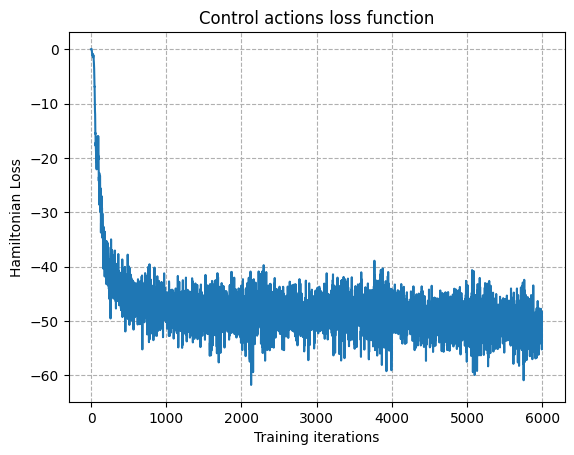

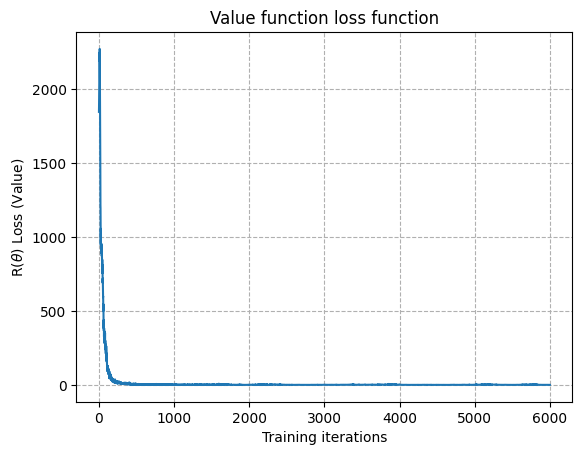

In [34]:
# Set batch size
batch_size = 2000

# Set the neural network for the optimal value function
sizes = [time_tensor_dim + space_tensor_dim, 100, 100, 2]
q_4_a_model = FFN(sizes = sizes)
optimizer_a = torch.optim.Adam(q_4_a_model.parameters(), lr=0.001)

# Set the neural network for the optimal value function
q_4_v_model = Net_DGM(dim_x=time_tensor_dim + space_tensor_dim - 1, dim_S=dmg_hidden_layer_size)
optimizer_v = torch.optim.Adam(q_4_v_model.parameters(), lr=0.001)

# Retrieve the trained Deep Galerkin Model, which finds the optimal value function for a fixed control a
u_model = dgm_q_4

losses_a = []
losses_v = []

for i in range(6000): #4000
    if i % 1000 == 0:
        print('Iteration {}'.format(i))
    q_4_t_tensor = torch.tensor(np.random.uniform(low=0, high=T, size=batch_size)).unsqueeze(1)
    q_4_x_tensor = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size,1, 2)),requires_grad=True)
    q_4_x_reshaped = q_4_x_tensor.reshape(-1, 2)
    q_4_input_tensor = torch.cat((q_4_t_tensor, q_4_x_reshaped), dim=1)

    # Generate the candidate optimal control for this time space batch
    q_4_a_pred = q_4_a_model.forward(q_4_input_tensor).to(torch.float64)

    # Fix it and feed it to the Deep Galerkin model to get the optimal PDE calculated value
    q_4_v_actual = u_model.forward_mod(q_4_t_tensor, q_4_x_reshaped, q_4_a_pred)
        
    # Generate the optimal value for this time space batch
    q_4_v_approx = q_4_v_model.forward(q_4_t_tensor, q_4_x_reshaped)
    
    # Update theta val
    optimizer_v.zero_grad()
    mse_loss = nn.MSELoss()
    loss_v = mse_loss(q_4_v_approx, q_4_v_actual)
    losses_v.append(loss_v.item())
    loss_v.backward(retain_graph=True)
    optimizer_v.step()

    #ii
    v_approx = q_4_v_model.forward(q_4_t_tensor, q_4_x_reshaped) #q_4_v_approx

    # Approximate v using the trained model
    grad_u_x = torch.autograd.grad(v_approx, q_4_x_reshaped, grad_outputs=torch.ones_like(v_approx), create_graph=True, retain_graph=True, only_inputs=True)[0]

    # Calculate each term
    term1 = torch.sum(grad_u_x * (torch.tensor(H, dtype=torch.float64) @ q_4_x_reshaped.T).T, dim=1, keepdim=True)  # (∇xv)ᵀHx
    term2 = torch.sum(grad_u_x * (torch.tensor(M, dtype=torch.float64) @ q_4_a_pred.T).T, dim=1, keepdim=True)      # (∇xv)ᵀMa
    term3 = torch.sum(q_4_x_reshaped * (torch.tensor(C, dtype=torch.float64) @ q_4_x_reshaped.T).T, dim=1, keepdim=True)  # (x)ᵀCx
    term4 = torch.sum(q_4_a_pred * (torch.tensor(D, dtype=torch.float64) @ q_4_a_pred.T).T, dim=1, keepdim=True)         # aᵀDa

    # Combine the terms
    hamiltonian = term1 + term2 + term3 + term4

    optimizer_a.zero_grad()
    mae_loss_h = MeanErrorLoss() #nn.L1Loss()
    loss_a_ham = mae_loss_h(hamiltonian, torch.zeros_like(hamiltonian))
    loss_a_ham.backward(retain_graph=True)
    optimizer_a.step()
    losses_a.append(loss_a_ham.item())

 # Plot training loss graph
plt.plot(losses_a[1:])
plt.grid(True, which="both", ls="--")
plt.xlabel('Training iterations')
plt.ylabel('Hamiltonian Loss')
plt.title('Control actions loss function')
plt.show()

 # Plot training loss graph
plt.plot(losses_v[1:])
plt.grid(True, which="both", ls="--")
plt.xlabel('Training iterations')
plt.ylabel(r'R($\theta$) Loss (Value)')
plt.title('Value function loss function')
plt.show()

In [25]:
# Compare with 1.1
batch_size = 1
# Sample t uniformly on [0, T]
t_tensor = torch.tensor(np.random.uniform(low=0, high=1, size=batch_size)).unsqueeze(1)
x_tensor = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size, 1, 2)))

time_grid = np.linspace(t0, T, 10000)
lqr_q_4 = LQRProblem(H, M, C, D, R, sigma, T)
lqr_q_4.solve_riccati_ode(time_grid)

x_reshaped = x_tensor.reshape(-1, 2)
input_tensor = torch.cat((t_tensor, x_reshaped), dim=1)

# Define loss function
loss_fn = torch.nn.MSELoss()

# Compare a_pred and a from 1.1
a_pred = q_4_a_model.forward(input_tensor).to(torch.float64).squeeze()
a_actual = lqr_q_4.compute_markov_control(t_tensor, x_tensor).squeeze()

print(f'MSE of a: {loss_fn(a_pred, a_actual)}')
print(f'Control actual {a_actual.detach().numpy()} \nControl prediction {a_pred.detach().numpy()}')

# #
# Compare v_pred and v from 1.1
v_pred = q_4_v_model.forward(t_tensor, x_reshaped).squeeze()
t_tensor_vi = t_tensor.squeeze(0)
x_tensor_vi = x_tensor.squeeze(0)
v_actual = lqr_q_4.compute_value_function(t_tensor_vi, x_tensor_vi).squeeze()

# plt.plot(np.array(v_pred), np.array(v_actual))
print(f'Absolute error of v: {abs(v_pred-v_actual)}')
print(f'Value actual {v_actual} \nValue prediction {v_pred}')

MSE of a: 0.6200285716233849
Control actual [-3.0171711  -1.33980294] 
Control prediction [-4.06045428 -1.72918365]
Absolute error of v: 1.753862068915529
Value actual 6.0202327881556865 
Value prediction 7.774094857071216


Comparison with Question 1.1 Batch size of 1000
MSE of actions: 1.273142670619465
MSE of value: 5.693392604612989


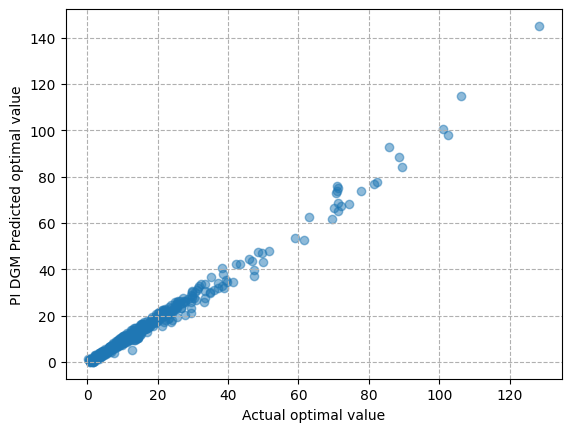

In [15]:
# Compare with 1.1 Batch Values
print('Comparison with Question 1.1 Batch size of 500')
batch_size = 500
# Sample t uniformly on [0, T]
batch_t_tensor = torch.tensor(np.random.uniform(low=0, high=1, size=batch_size)).unsqueeze(1)
batch_x_tensor = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size, 2)))
batch_x_reshaped = batch_x_tensor.reshape(-1, 2)
input_tensor = torch.cat((batch_t_tensor, batch_x_reshaped), dim=1)

# Define loss function
loss_fn = torch.nn.MSELoss()

# Compare a_pred and a from 1.1
a_pred = q_4_a_model.forward(input_tensor).to(torch.float64)
a_actual = lqr_q_4.compute_markov_control(batch_t_tensor, batch_x_tensor)
print(f'MSE of actions: {loss_fn(a_pred, a_actual.squeeze())}')
# #

# # Compare v_pred and v from 1.1
v_pred = q_4_v_model.forward(batch_t_tensor, batch_x_reshaped).squeeze()
batch_t_tensor_vi = batch_t_tensor.T.squeeze(0)
v_actual = lqr_q_4.compute_value_function(batch_t_tensor_vi, batch_x_tensor).squeeze()
print(f'MSE of value: {loss_fn(v_pred, v_actual)}')

plt.scatter(v_pred.detach().numpy(), v_actual.detach().numpy(), alpha=0.5)
plt.grid(True, which="both", ls="--")
plt.xlabel('Actual optimal value')
plt.ylabel('PI DGM Predicted optimal value')
plt.show()

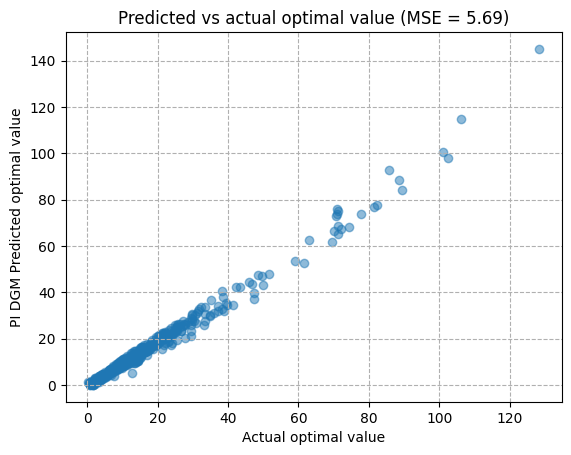

In [21]:
plt.scatter(v_pred.detach().numpy(), v_actual.detach().numpy(), alpha=0.5)
plt.grid(True, which="both", ls="--")
plt.title(f'Predicted vs actual optimal value (MSE = {(loss_fn(v_pred, v_actual)):.2f})')
plt.xlabel('Actual optimal value')
plt.ylabel('PI DGM Predicted optimal value')
plt.show()

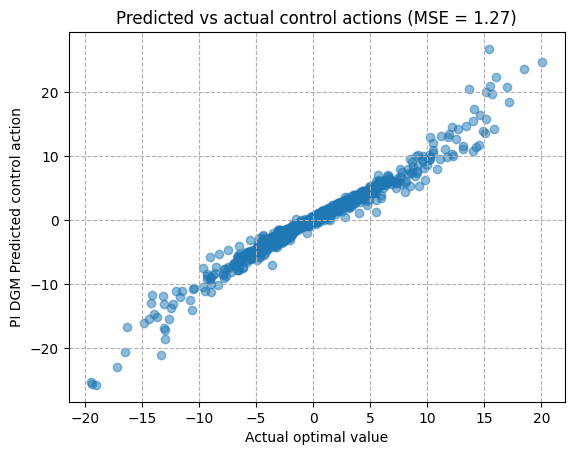

In [23]:
plt.scatter(a_pred.detach().numpy(), a_actual.detach().numpy(), alpha=0.5)
plt.grid(True, which="both", ls="--")
plt.title(f'Predicted vs actual control actions (MSE = {(loss_fn(a_pred, a_actual.squeeze())):.2f})')
plt.xlabel('Actual optimal value')
plt.ylabel('PI DGM Predicted control action')
plt.show()